In [1]:
# All imports and downloads
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
import librosa
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from plotnine import ggplot, aes, geom_line, facet_wrap, theme_bw, theme, scale_x_continuous, element_blank, labs
from keras import regularizers

import re
import os
import sys

In [2]:
# clones the github repository for use in google colab notebooks
from google.colab import userdata
accessToken = userdata.get('AccessToken') # Access token connects notebook to the github data folders

# accesses the github dataset by cloning the repository and downloading its contents
token = accessToken
repo_url = f"https://{token}@github.com/SleepDeprived3/Bias-in-Emotion-Recognition.git"
!git clone {repo_url}

Cloning into 'Bias-in-Emotion-Recognition'...
remote: Enumerating objects: 9716, done.
remote: Counting objects: 100% (93/93), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 9716 (delta 48), reused 24 (delta 10), pack-reused 9623 (from 3)
Receiving objects: 100% (9716/9716), 1.29 GiB | 48.44 MiB/s, done.
Resolving deltas: 100% (52/52), done.
Updating files: 100% (9603/9603), done.


## Experiment 1 - Creating an emotion-classifying LSTM using Crema-D training data

##Loading and Cleaning the Data

In [3]:
# finds the directory list of all audio files
directory_list = os.listdir("/content/Bias-in-Emotion-Recognition/data/Crema-D/AudioWAV")

# creates empty variable lists for audio file variable storage
path = []
id = []
phrase = []
emotion = []
intensity = []

# for each audio file in the list, adds information from the audio file name into the
# appropriate variable list
for item_name in directory_list:
  path.append(item_name)
  filtered_name = item_name.removesuffix(".wav")
  structure = filtered_name.split("_")
  if (len(structure) == 4):
    id.append(structure[0])
    phrase.append(structure[1])
    emotion.append(structure[2])
    intensity.append(structure[3])

# creates a pandas dataframe containing all crema-D audio file pathways and information
# using the previously created variable lists
crema_d_df = pd.DataFrame(zip(path, id, phrase, emotion, intensity))
crema_d_df.columns = ["path", "id", "phrase", "emotion", "intensity"]
crema_d_df

,path,id,phrase,emotion,intensity
0,1020_TAI_HAP_XX.wav,1020,TAI,HAP,XX
1,1020_IWW_DIS_XX.wav,1020,IWW,DIS,XX
2,1023_IWW_HAP_XX.wav,1023,IWW,HAP,XX
3,1033_IEO_HAP_LO.wav,1033,IEO,HAP,LO
4,1065_ITH_DIS_XX.wav,1065,ITH,DIS,XX
...,...,...,...,...,...
7437,1050_ITH_ANG_XX.wav,1050,ITH,ANG,XX
7438,1090_TSI_HAP_XX.wav,1090,TSI,HAP,XX
7439,1072_TSI_DIS_XX.wav,1072,TSI,DIS,XX
7440,1039_IWW_ANG_XX.wav,1039,IWW,ANG,XX


## Demographics Data - Initial Analysis

In [4]:
# saving the demographic data as a pandas dataframe and inspecting its shape
demog_df = pd.read_csv('/content/Bias-in-Emotion-Recognition/data/Crema-D/VideoDemographics.csv')
demog_df

,ActorID,Age,Sex,Race,Ethnicity
0,1001,51,Male,Caucasian,Not Hispanic
1,1002,21,Female,Caucasian,Not Hispanic
2,1003,21,Female,Caucasian,Not Hispanic
3,1004,42,Female,Caucasian,Not Hispanic
4,1005,29,Male,African American,Not Hispanic
...,...,...,...,...,...
86,1087,62,Male,Caucasian,Not Hispanic
87,1088,23,Male,African American,Not Hispanic
88,1089,24,Female,Caucasian,Not Hispanic
89,1090,50,Male,Asian,Not Hispanic


**Checking Actor IDs Match**



In [5]:
# type casts the ID values of the demographic datframe and crema D dataframe
# to be strings, which will allow for dataframe merging by ID
demog_df['ActorID'] = demog_df['ActorID'].astype(str)
crema_d_df['ActorID'] = crema_d_df['id'].astype(str)

**Merge demographics info into parent dataframe**

In [6]:
# merges dataframe based on the ActorID to combine audio paths and emotion
# information with demographic information
df = crema_d_df.merge(demog_df, on='ActorID')
df = df.drop(columns=["id"])
df.head()

,path,phrase,emotion,intensity,ActorID,Age,Sex,Race,Ethnicity
0,1020_TAI_HAP_XX.wav,TAI,HAP,XX,1020,61,Female,Caucasian,Not Hispanic
1,1020_IWW_DIS_XX.wav,IWW,DIS,XX,1020,61,Female,Caucasian,Not Hispanic
2,1023_IWW_HAP_XX.wav,IWW,HAP,XX,1023,22,Male,Caucasian,Not Hispanic
3,1033_IEO_HAP_LO.wav,IEO,HAP,LO,1033,31,Male,Caucasian,Not Hispanic
4,1065_ITH_DIS_XX.wav,ITH,DIS,XX,1065,38,Male,Caucasian,Not Hispanic



**Training and Testing**

In [7]:
# A summary dataframe for the race statistics in Crema-D
features = ["Age", "Sex", "Race"]
X = df[features]
y = df["emotion"]

train, test = train_test_split(df, test_size=0.2, random_state=42)

X_train, X_test = train[features], test[features]
y_train, y_test = train["emotion"], test["emotion"]

**Summary Tables**

In [8]:
# A summary dataframe for the age statistics in Crema-D
age_summary = test.groupby("emotion")["Age"].mean()
age_summary

,Age
emotion,
ANG,36.323887
DIS,35.494340
FEA,36.264925
HAP,35.745763
NEU,36.723502
SAD,36.597656


In [9]:
# A summary dataframe for the gender statistics in Crema-D
gender_summary = test.groupby(["emotion", "Sex"]).size().unstack(fill_value=0)
gender_summary

Sex,Female,Male
emotion,,
ANG,119,128
DIS,115,150
FEA,133,135
HAP,123,113
NEU,99,118
SAD,123,133


In [10]:
# A summary dataframe for the race statistics in Crema-D
race_summary = test.groupby(["emotion", "Race"]).size().unstack(fill_value=0)
race_summary

Race,African American,Asian,Caucasian,Unknown
emotion,,,,
ANG,56,16,171,4
DIS,70,29,165,1
FEA,58,23,185,2
HAP,61,11,160,4
NEU,54,14,147,2
SAD,72,18,163,3


**Plots**

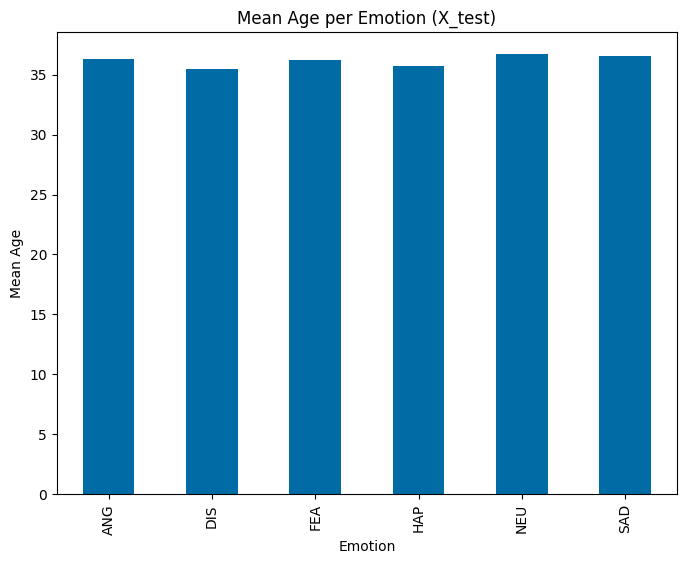

Alt text: A graph showing the mean participant ages per emotion for the Crema-D dataset. Mean ages are about equal for each emotion.


In [82]:
# Age distribution per emotion
plt.style.use('tableau-colorblind10')
plt.figure(figsize=(8,6))
test.groupby("emotion")["Age"].mean().plot(kind="bar")
plt.title("Mean Age per Emotion (X_test)")
plt.ylabel("Mean Age")
plt.xlabel("Emotion")
plt.show()
print("Alt text: A graph showing the mean participant ages per emotion for the Crema-D dataset. Mean ages are about equal for each emotion.")

<Figure size 1000x600 with 0 Axes>

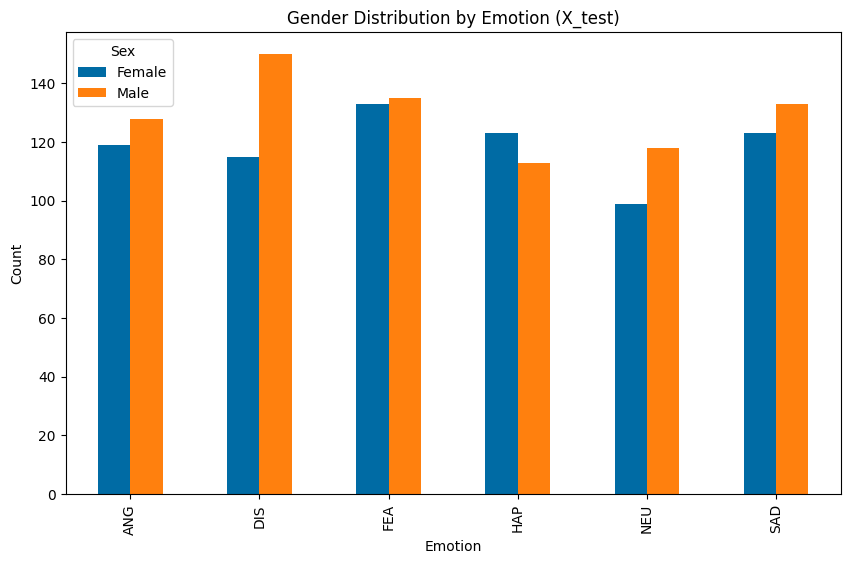

Alt text: A graph showing the genders of the participant per emotion for the Crema-D dataset. Gender distributions vary for each emotion, but seem to be slightly male-weighted (except for Happy, which appears to be female-weighted).


In [83]:
# Sex distribution per emotion
plt.style.use('tableau-colorblind10')
plt.figure(figsize=(10,6))
test.groupby(["emotion", "Sex"]).size().unstack().plot(kind="bar", figsize=(10,6))
plt.title("Gender Distribution by Emotion (X_test)")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.show()
print("Alt text: A graph showing the genders of the participant per emotion for the Crema-D dataset. Gender distributions vary for each emotion, but seem to be slightly male-weighted (except for Happy, which appears to be female-weighted).")

<Figure size 1000x600 with 0 Axes>

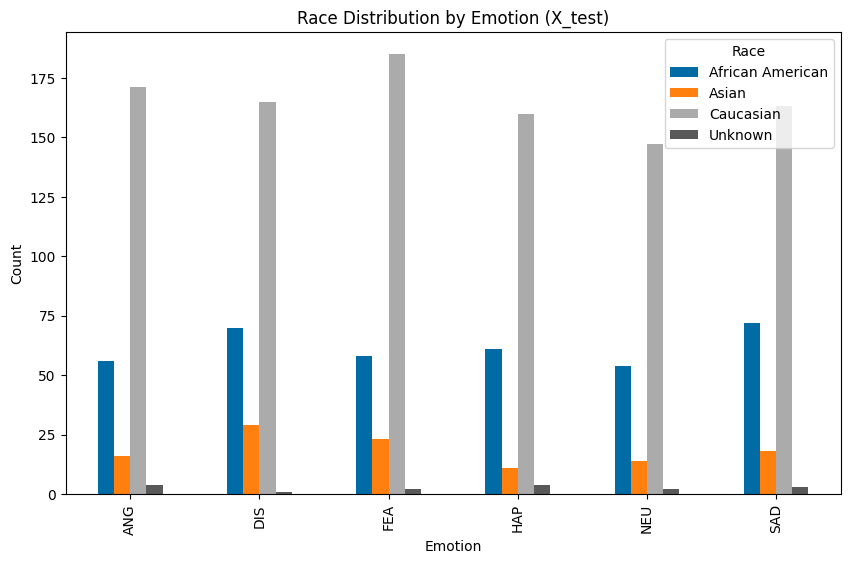

Alt text: A graph showing the race distribution of participants per emotion for the Crema-D dataset. While there are some inter-emotion differences, all emotions are represented predominantly by caucasian speakers.


In [84]:
# Race distribution per emotion
plt.style.use('tableau-colorblind10')
plt.figure(figsize=(10,6))
test.groupby(["emotion", "Race"]).size().unstack().plot(kind="bar", figsize=(10,6))
plt.title("Race Distribution by Emotion (X_test)")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.show()
print("Alt text: A graph showing the race distribution of participants per emotion for the Crema-D dataset. While there are some inter-emotion differences, all emotions are represented predominantly by caucasian speakers.")

## Creating the LSTM model

First, we are going to use the librosa library to extract audio features (Mel-Frequency Cepstrak Coefficient features, or MFCCs) from each audio file in the Crema-D dataset. These features will be added to a list, which will eventually be used to fit the LSTM model. The list is then padded in order to ensure that each series of MFCCs is the same length (preventing audio clip length from disrupting the model's input size).

When loading librosa features, most of the variable are set to default values for human speech. Additionally, a value of 40 MFCC features (for variable n_mfcc) was chosen in order to obtain a higher level of detail for each continuous audio clip.

In [14]:
my_num_mfcc=40  # typical number of mfcc features
my_n_fft=2048  # default audio sampling rate
my_hop_length=512  # default hop length value (256 if you want tailored to speech)
my_sample_rate = 22050  # default sampling rate (in Hz)

def extract_features(filename):
  # a function which utilizes the librosa audio-processing library to extract numeric
  # audio features from an audio file (provided by a .wav path). Returns the audio features.
  y, sr = librosa.load(filename, sr=my_sample_rate)

  # turning audio data into Mel-Frequency Cepstral Coefficient features (which represent the power
  # spectra of sound) using the librosa library
  mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=my_num_mfcc, n_fft=my_n_fft, hop_length=my_hop_length).T
  return mfcc

# an empty list which will save extracted audio features for each audio sequence
extracted_features = []

# creating LSTM features for each audio file in the dataset using a list of each audio path
path_prefix = "/content/Bias-in-Emotion-Recognition/data/Crema-D/AudioWAV/"
for file_row in range(len(crema_d_df)):
  extracted_features.append(extract_features(path_prefix + crema_d_df.iloc[file_row, 0]))

# preprocesses the audio feature sequences by adding padding (0 values) to the audio feature
# sequences, allowing sequences to be equal in length without shifting connection weights
# within the model
extracted_features_padded = keras.preprocessing.sequence.pad_sequences(extracted_features)

The following code is used to create the LSTM model in keras/tensorflow.

 The created model takes in an input shape that is consistent with the number of MFCCs defined when loading the audio file features using the librosa library (n_mfcc). It contains 2 LSTM layers (each with 250 units), an initial dense layer (with an l2 regularizer and a relu activation) with 100 units, a dropout layer with a value of 0.3, a second dense layer with 80 units (with an l2 regularizer and a relu activation), and an output layer that outputs (a one-hot encoding that describes) one of six possible emotions.  

In [28]:
# creating an LSTM model which inputs audio feature sequences and outputs one of the six
# Crema-D-identified emotions

# ------

# input layer that takes in the audio feature sequences
input = keras.layers.Input((None, extracted_features_padded.shape[2]))

# LSTM layers for sequential audio feature processing
lstm1 = keras.layers.LSTM(250, return_sequences=True)(input)
lstm2 = keras.layers.LSTM(250, return_sequences=False)(lstm1)

# Two dense layers with dropout to learn higher-level patterns and prevent overfitting by
# dropping 30% of the learned information
dense1 = keras.layers.Dense(100, kernel_regularizer=regularizers.l2(), activation="relu")(lstm2)
dropout1 = keras.layers.Dropout(0.3)(dense1)
dense2 = keras.layers.Dense(80, kernel_regularizer=regularizers.l2(), activation="relu")(dropout1)

# A final softmax dense layer to allow the model to classify the patterns as one of the six emotions
output = keras.layers.Dense(crema_d_df['emotion'].nunique(), activation="softmax")(dense2)

# Crreates the model using the input layer as an input and the softmax layer as an output
lstm_emotion_identification_model = keras.Model(inputs=input, outputs=output)
lstm_emotion_identification_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, 40)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, None, 250)      │       291,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 250)            │       501,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        25,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 80)             │         8,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           486 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 825,666 (3.15 MB)

 Trainable params: 825,666 (3.15 MB)

 Non-trainable params: 0 (0.00 B)

Compiles the LSTM model using an Adam optimizer with a learning rate of 0.001. Also sets up categorical cross-entropy and categorical accuracy as the loss and metric values respectfully.

In [29]:
# Compiles the model with the necessary tools and metrics to track accuracy
# and make internal weight adjustments
lstm_emotion_identification_model.compile(
  optimizer=keras.optimizers.Adam(learning_rate=0.001),
  loss=keras.losses.CategoricalCrossentropy(),
  metrics = [keras.metrics.CategoricalAccuracy()]
)

Preprocesses the X and Y values for the model by generating one-hot encodings for the Y values and setting the X values equal to the padded MFCC features.

In [30]:
# setting up X variables
X = extracted_features_padded

# one-hot encoding y_variables
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(crema_d_df['emotion'])
y = tf.keras.utils.to_categorical(y_encoded, crema_d_df['emotion'].nunique())

Fits the model using 40 epochs and a batch size of 30. Shuffles training examples in order to minimize overfitting caused by repeated audio clips taken from the same subject. Also implements early stopping in order to prevent the model from drastically overfitting.

In [31]:
# Fitting the model on the training data with an 80-20 training-testing split.
# Attempts to reach 40 training epochs, but stops early with enough overfitting.
# Adjusts weights and biases every 30 training samples.
keras.backend.clear_session()
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="val_loss", patience = 4)
fit_model = lstm_emotion_identification_model.fit(X, y, validation_split=0.2, epochs=40, batch_size=30, shuffle=True, callbacks=[early_stopping_callback])

Epoch 1/40
199/199 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - categorical_accuracy: 0.2926 - loss: 3.0077 - val_categorical_accuracy: 0.3936 - val_loss: 1.7293
Epoch 2/40
199/199 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - categorical_accuracy: 0.3651 - loss: 1.7222 - val_categorical_accuracy: 0.3875 - val_loss: 1.6100
Epoch 3/40
199/199 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - categorical_accuracy: 0.3876 - loss: 1.5901 - val_categorical_accuracy: 0.4063 - val_loss: 1.5061
Epoch 4/40
199/199 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - categorical_accuracy: 0.3874 - loss: 1.5455 - val_categorical_accuracy: 0.4177 - val_loss: 1.4673
Epoch 5/40
199/199 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - categorical_accuracy: 0.3941 - loss: 1.5008 - val_categorical_accuracy: 0.4325 - val_loss: 1.4515
Epoch 6/40
199/199 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - categorical_accuracy: 0.4053 - loss: 1.4813 - val_categorical_accuracy: 0.4285 - val_loss: 1.4563
Epoch 7/40
199/199 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - categorical_accuracy: 0.403

Plots the accuracy and loss values of the model (on both training and testing data).

In [103]:
def plot_fit_history(history):
  # Takes in model training history and returns a plot that shows model accuracy
  # and loss over time for both the training and the testing data. Used to examine
  # model accuracy and overfitting.
  df = pd.DataFrame(history.history)
  df['epoch'] = np.arange(len(df))

  # Reshape the dataframe to long format
  df_longer = df.melt(id_vars=['epoch'], var_name="measure", value_name="value")

  # Extract measure name and data type (train or validation)
  df_longer['data_type'] = df_longer['measure'].apply(lambda x: 'validation' if x.startswith('val_') else 'training')
  df_longer['measure'] = df_longer['measure'].apply(lambda x: re.sub('val_', '', x))

  return (ggplot(df_longer, mapping=aes(x="epoch", y="value", color="data_type"))+
   geom_line()+
   scale_x_continuous(breaks=np.arange(0, len(df)))+
   facet_wrap('~measure', scales='free_y')+
   labs(x = "Epoch", y="", color="Dataset")+
   theme_bw()+
   theme(panel_grid=element_blank()))


Alt text: A graph showing the categorical accuracy and loss of the LSTM model. Training and validation data split indicates slight overfitting by the end of the training period, but significantly higher accuracy than random chance.


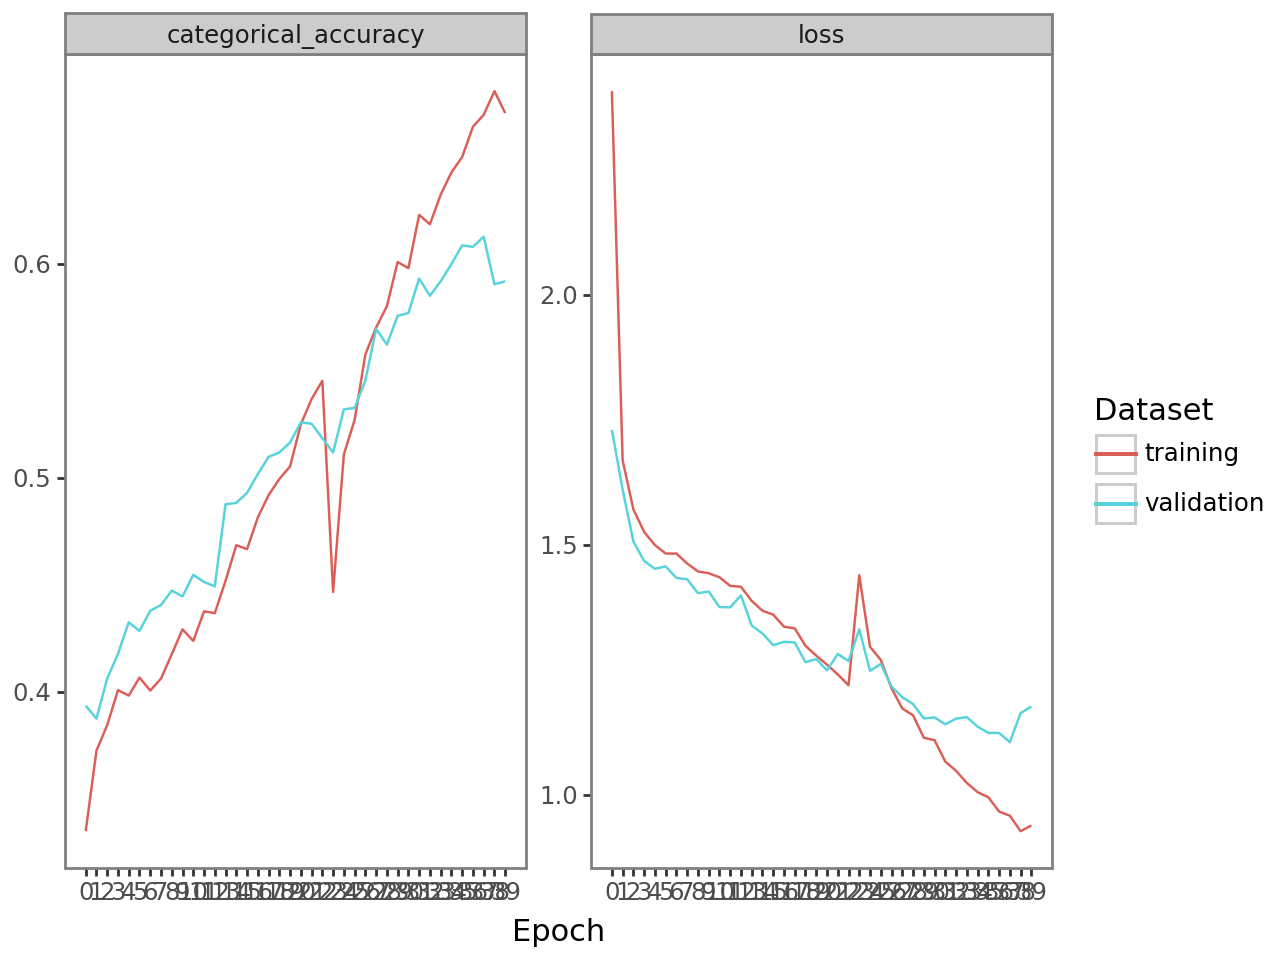

In [107]:
print("Alt text: A graph showing the categorical accuracy and loss of the LSTM model. Training and validation data split indicates slight overfitting by the end of the training period, but significantly higher accuracy than random chance.")
plot_fit_history(fit_model)

As you can see, the model is slowly increasing in accuracy over successive training examples. While the training data and testing data display mostly similar accuracy and loss values throughout training, the early stopping command prevents the model from overfitting once the testing and training data begin to significantly diverge.

**Speech Accent Archive Data**

Loads the audio clips collected from the Speech Accent Archive using the same methods as the Crema-D dataset.

In [36]:
# finds the directory list of all audio files
directory_list = os.listdir("/content/Bias-in-Emotion-Recognition/data/Speech Accent Archive/recordings")

# creates empty variable lists for each speech accent archive variable we need for our analysis
ssa_path = []
ssa_accent = []
ssa_number = []

# for each audio file in the list, adds information from the audio file name into the
# appropriate variable list
for item_name in directory_list:
  ssa_path.append(item_name)
  filtered_name = item_name.removesuffix(".mp3")
  accent_string = ""
  number_string = ''
  for character in filtered_name:
    if character.isdigit():
      number_string = number_string + character
    else:
      accent_string = accent_string + character
  ssa_accent.append(accent_string)
  ssa_number.append(number_string)

# creates a pandas dataframe using the previously created variable lists
ssa_df = pd.DataFrame(zip(ssa_path, ssa_accent, ssa_number))
ssa_df.columns = ["path", "accent", "number"]
ssa_df

,path,accent,number
0,spanish158.mp3,spanish,158
1,afrikaans1.mp3,afrikaans,1
2,spanish49.mp3,spanish,49
3,english336.mp3,english,336
4,german22.mp3,german,22
...,...,...,...
2133,arabic28.mp3,arabic,28
2134,english366.mp3,english,366
2135,ukrainian9.mp3,ukrainian,9
2136,english64.mp3,english,64


Extracts MFCC features from the Speech Accent Archive using the same function as we used on the Crema-D dataset.

In [37]:
# creating features for each audio file in the dataset using the audio pathways of each
# speech accent archive recording
ssa_extracted_features = []

path_prefix = "/content/Bias-in-Emotion-Recognition/data/Speech Accent Archive/recordings/"
for file_row in range(len(ssa_df)):
  ssa_extracted_features.append(extract_features(path_prefix + ssa_df.iloc[file_row, 0]))

ssa_extracted_features_padded = keras.preprocessing.sequence.pad_sequences(ssa_extracted_features)

Creates a series of predictions about the emotions displayed in the Speech Accent Archive dataset using the Crema-D-trained LSTM model.

In [38]:
# Applies the LSTM emotion classifier model to the speech accent archive and makes predictions
# about the emotions of every accent archive audio clip.
ssa_prediction = lstm_emotion_identification_model.predict(ssa_extracted_features_padded)

67/67 ━━━━━━━━━━━━━━━━━━━━ 11s 164ms/step


Transforms each prediction output by the LSTM model from a one-hot encoding to one of the six Crema-D emotions. Adds each emotion to the Speech Accent Archive dataframe.

In [39]:
# Creates a dataframe row for the speech accent which contains the LSTM model predictions.
# Decodes the one-hot encodings for these predictions using the label-encoder
emotion_predictions = []

for file_row in range(len(ssa_prediction)):
  ssa_prediction_argmax = np.argmax(ssa_prediction, axis=-1)
  ssa_prediction_emotion = label_encoder.inverse_transform(ssa_prediction_argmax)
  ssa_df.loc[file_row, 'crema-d predictions'] = ssa_prediction_emotion[file_row]

ssa_df

,path,accent,number,crema-d predictions
0,spanish158.mp3,spanish,158,NEU
1,afrikaans1.mp3,afrikaans,1,DIS
2,spanish49.mp3,spanish,49,DIS
3,english336.mp3,english,336,ANG
4,german22.mp3,german,22,ANG
...,...,...,...,...
2133,arabic28.mp3,arabic,28,DIS
2134,english366.mp3,english,366,NEU
2135,ukrainian9.mp3,ukrainian,9,DIS
2136,english64.mp3,english,64,ANG


In [40]:
# counts the number of unique accents in the speech accent archive
ssa_df["accent"].nunique()

200

Creates three dataframes that filter for the top five most represented, second five most represented, and all other represented accents in the greater, emotion-predicted speech accent archive dataframe. It should be noted that the first two dataframes collectively represent 1203 audio files, or 56.27% of the speech accent archive dataset.

In [41]:
# Creates three groups of accents for graphing: the top five most represented accents,
# the next five most represented accents, and a group that merges all other accents
accent_grouping = ssa_df.groupby(["accent"])["crema-d predictions"].count()
most_common_accents = accent_grouping.sort_values(ascending=False)
accents_by_count = most_common_accents.index.tolist()
accents_by_count_top_five = accents_by_count[0:5]
accents_by_count_next_five = accents_by_count[5:10]
accents_by_count_else = accents_by_count[10:]

filtered_emotion_df_top = ssa_df[ssa_df['accent'].isin(accents_by_count_top_five)]
filtered_emotion_df_next = ssa_df[ssa_df['accent'].isin(accents_by_count_next_five)]
filtered_emotion_df_else = ssa_df[ssa_df['accent'].isin(accents_by_count_else)]

Initial plots showing the counts of different emotions displayed in the three previously described dataframes. The graphs will need to be adjusted to account for the relative frequencies of each accent in order to allow for comparisons between emotion frequencies.

<Figure size 640x480 with 0 Axes>

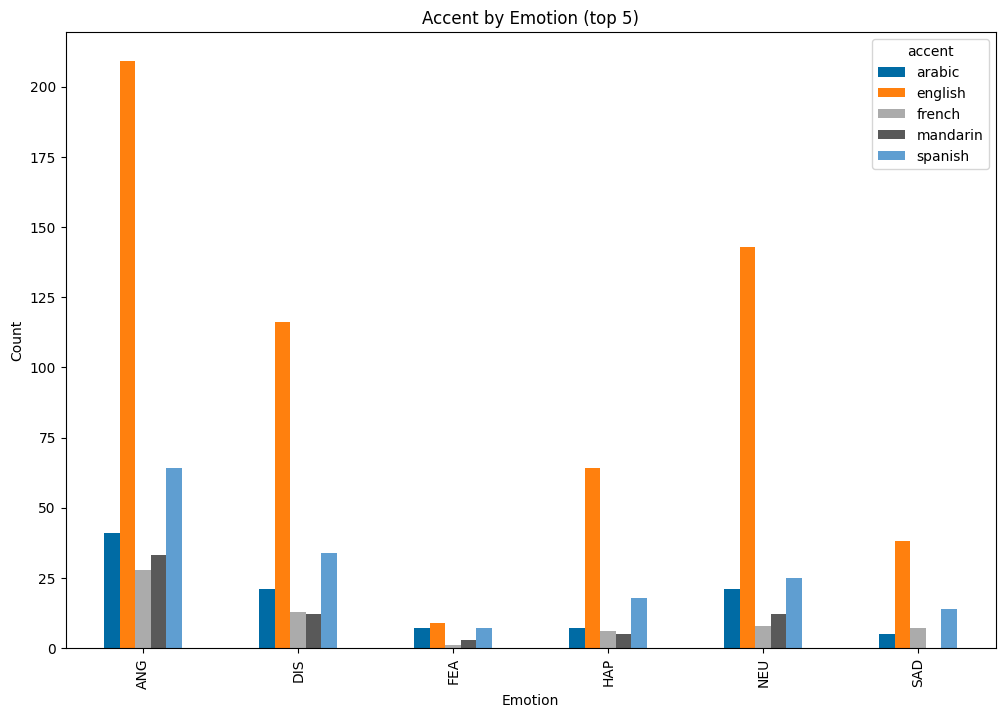

Alt text: A chart showing total counts for accent classification in the top five most represented speech accent archive languages. English, being the predominantly represented language in the dataset, has much higher counts than any other language.


In [108]:
# Classification counts of the five most represented accents
plt.style.use('tableau-colorblind10')
plt.figure()
filtered_emotion_df_top.groupby(["crema-d predictions", "accent"]).size().unstack().plot(kind="bar", figsize=(12,8))
plt.title("Accent by Emotion (top 5)")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.show()
print("Alt text: A chart showing total counts for accent classification in the top five most represented speech accent archive languages. English, being the predominantly represented language in the dataset, has much higher counts than any other language.")

<Figure size 640x480 with 0 Axes>

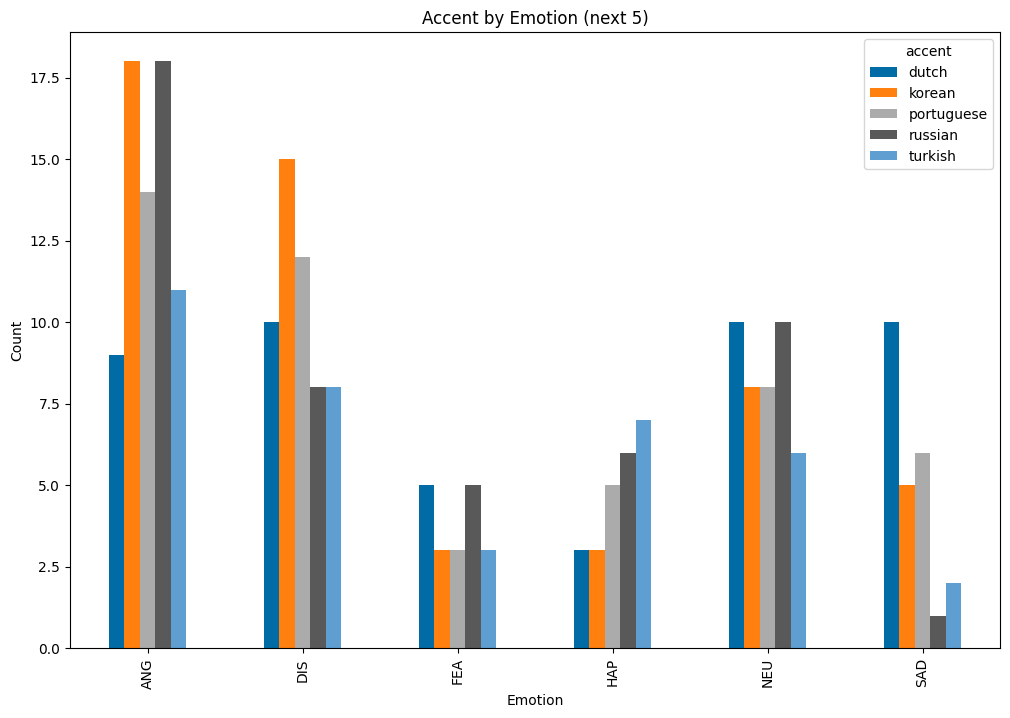

Alt text: A chart showing total counts for accent classification in the next five most represented speech accent archive languages.


In [110]:
# Classification counts of the five next most represented accents
plt.style.use('tableau-colorblind10')
plt.figure()
filtered_emotion_df_next.groupby(["crema-d predictions", "accent"]).size().unstack().plot(kind="bar", figsize=(12,8))
plt.title("Accent by Emotion (next 5)")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.show()
print("Alt text: A chart showing total counts for accent classification in the next five most represented speech accent archive languages.")

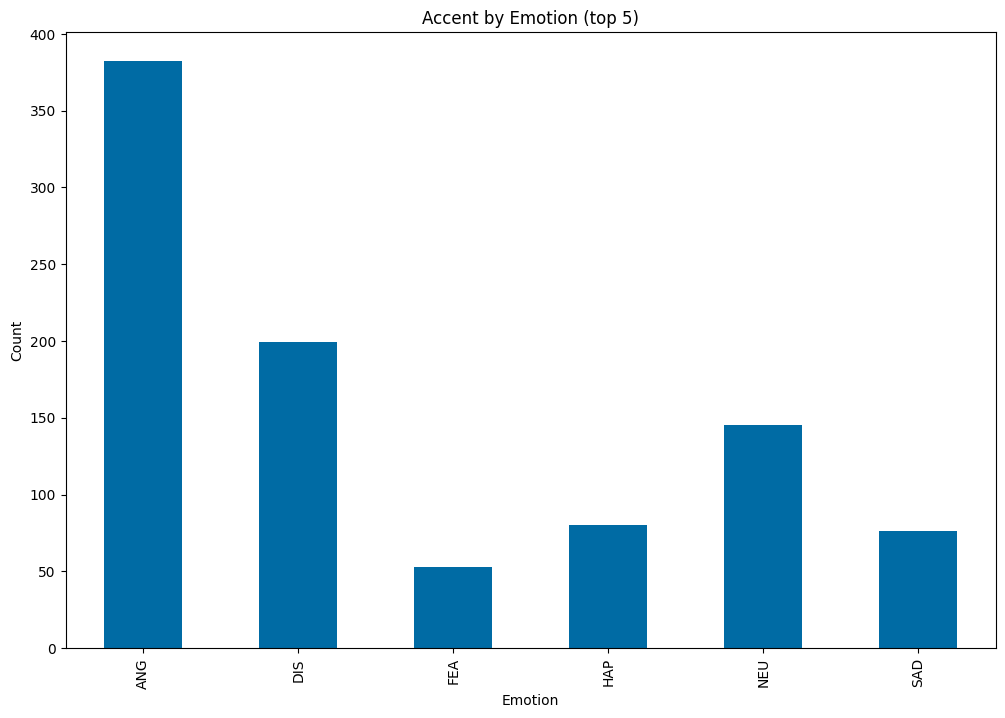

Alt text: A chart showing total counts for accent classification in the remaining speech accent archive languages.


In [109]:
# Classification counts of the rest of the accents (combined)
plt.style.use('tableau-colorblind10')
plt.figure()
filtered_emotion_df_else.groupby(["crema-d predictions"]).size().plot(kind="bar", figsize=(12,8))
plt.title("Accent by Emotion (top 5)")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.show()
print("Alt text: A chart showing total counts for accent classification in the remaining speech accent archive languages.")

In [45]:
# Creates relative dataframes that will show the classifications of different emotions in each
# accent relative to the total number of data entries for that accent
emotions_list = ["ANG", "DIS", "FEA", "HAP", "NEU", "SAD"]
top_relative_df = filtered_emotion_df_top.groupby(["crema-d predictions", "accent"]).size().unstack().reindex(emotions_list, fill_value=0)
next_relative_df = filtered_emotion_df_next.groupby(["crema-d predictions", "accent"]).size().unstack().reindex(emotions_list, fill_value=0)
else_relative_df = filtered_emotion_df_else.groupby(["crema-d predictions"]).size().reindex(emotions_list, fill_value=0)

Turns each count dataframe into a percentage dataframe, allowing relative frequencies of results to be compared between accents.

In [46]:
# For each relative dataframe, calculates the percentage of each emotion for an accent
# based on the total number of emotion ratings for an accent and the count of the emotion
for row in range(len(top_relative_df)):
  for accent in accents_by_count_top_five:
    for emotion in emotions_list:
      column_sum = top_relative_df[accent].sum()
      top_relative_df.loc[emotion, accent] = (top_relative_df.loc[emotion, accent] / column_sum) * 100

for row in range(len(next_relative_df)):
  for n_accent in accents_by_count_next_five:
    for n_emotion in emotions_list:
      column_sum = next_relative_df[n_accent].sum()
      next_relative_df.loc[n_emotion, n_accent] = (next_relative_df.loc[n_emotion, n_accent] / column_sum) * 100

else_percentage_list = []
column_sum_else = else_relative_df.sum()
for item in else_relative_df:
  else_percentage_list.append((item / column_sum_else) * 100)
data = {'Emotion': emotions_list, 'Percentage': else_percentage_list}
else_relative_df = pd.DataFrame(data)

/tmp/ipython-input-3840289625.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '34.61538461538461' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
/tmp/ipython-input-3840289625.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '29.166666666666668' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
/tmp/ipython-input-3840289625.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '37.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
/tmp/ipython-input-3840289625.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '19.148936170212767' has dtype 

<Figure size 640x480 with 0 Axes>

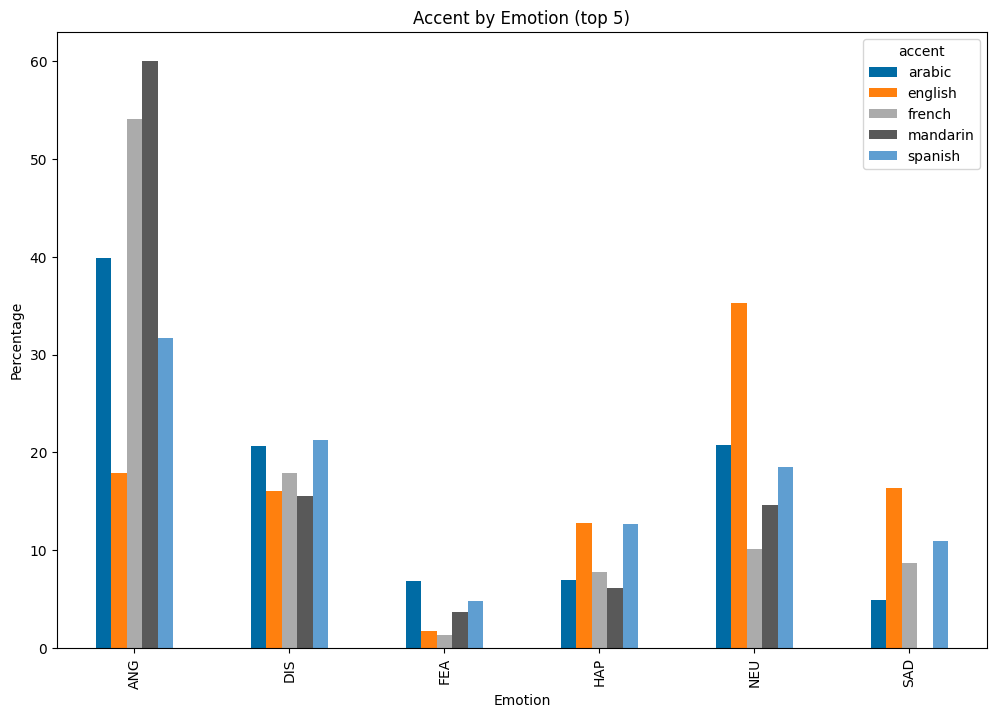

Alt text: A chart showing relative counts for accent classification in the top five most represented speech accent archive languages. While most languages are displayed as predominantly angry, Enlish is classified as predominantly neutral.


In [111]:
# Classification percentages of the five most represented accents
plt.style.use('tableau-colorblind10')
plt.figure()
top_relative_df.plot(kind="bar", figsize=(12,8))
plt.title("Accent by Emotion (top 5)")
plt.xlabel("Emotion")
plt.ylabel("Percentage")
plt.show()
print("Alt text: A chart showing relative counts for accent classification in the top five most represented speech accent archive languages. While most languages are displayed as predominantly angry, Enlish is classified as predominantly neutral.")

<Figure size 640x480 with 0 Axes>

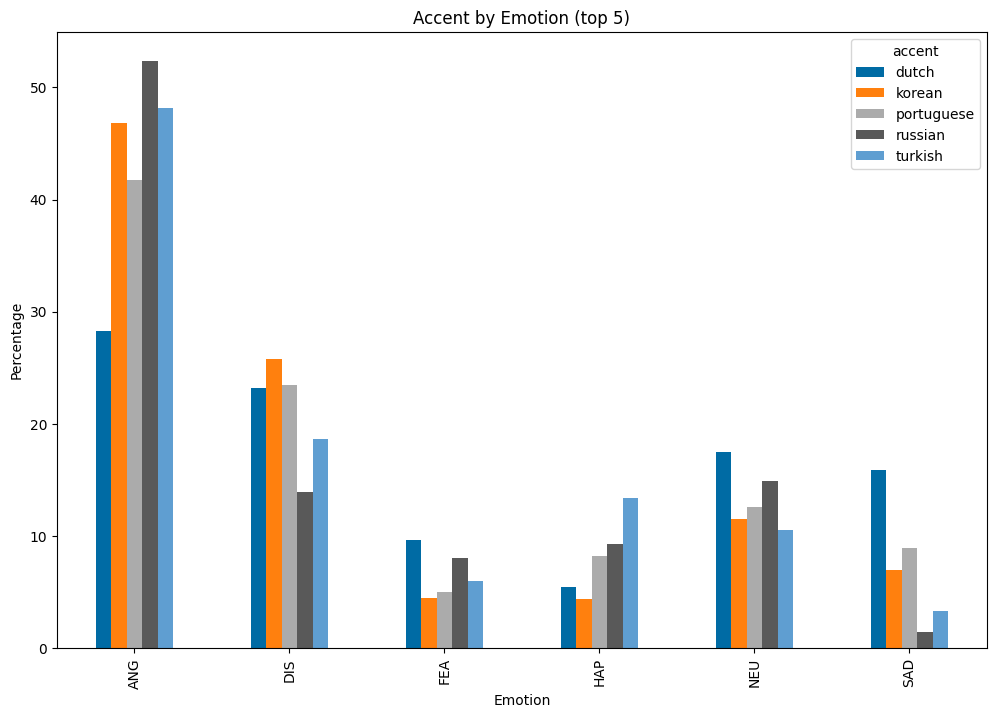

Alt text: A chart showing relative counts for accent classification in the next five most represented speech accent archive languages.


In [112]:
# Classification percentages of the next five most represented accents
plt.style.use('tableau-colorblind10')
plt.figure()
next_relative_df.plot(kind="bar", figsize=(12,8))
plt.title("Accent by Emotion (top 5)")
plt.xlabel("Emotion")
plt.ylabel("Percentage")
plt.show()
print("Alt text: A chart showing relative counts for accent classification in the next five most represented speech accent archive languages.")

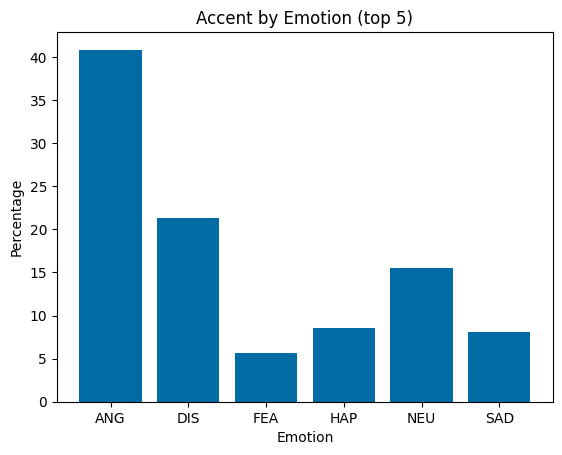

Alt text: A chart showing relative counts for accent classification in the remaining represented speech accent archive languages.


In [113]:
# Classification percentages of the rest of the accents (combined)
plt.style.use('tableau-colorblind10')
plt.figure()
plt.bar(else_relative_df['Emotion'], else_relative_df['Percentage'])
plt.title("Accent by Emotion (top 5)")
plt.xlabel("Emotion")
plt.ylabel("Percentage")
plt.show()
print("Alt text: A chart showing relative counts for accent classification in the remaining represented speech accent archive languages.")

## Examining Relationships Between Specific Accents

In [50]:
# Checks the dataframe to see which accents are most frequently represented
ssa_df.groupby(['accent']).count().sort_values(by=['path'], ascending=False).head(50)

,path,number,crema-d predictions
accent,,,
english,579,579,579
spanish,162,162,162
arabic,102,102,102
mandarin,65,65,65
french,63,63,63
korean,52,52,52
portuguese,48,48,48
russian,48,48,48
dutch,47,47,47


For our statistical testing, we are going to compare a standard english accent with accents from two underrepresented minorities in American society: Mandarin and Spanish.

Mandarin was chosen in order to fill the role of an accent that may be prevelant (even if only a little) in the accents of the Crema-D dataset. Since the Crema-D dataset utilized a small sample of (unspecified) Asian speakers, we chose to use the most well-represented Asian accent in the Speech Accent Archive (Mandarin) to test whether residual accents played in influence in model training.

Similarly, spanish was chosen in order to represent the most common foreign accent in the Speech Accent Archive that was not represented in the Crema-D speaker demographics.

In [51]:
# A targeted speech accent archive dataframe that only inspects the Mandarin,
# English, and Spanish language speakers
target_data = ssa_df[ssa_df['accent'].isin(['mandarin','english','spanish'])]

In [52]:
from scipy.stats import chi2_contingency

# Create a table with the total counts for each target accent
contingency_table = pd.crosstab(target_data['accent'], target_data['crema-d predictions'])

# Perform the chi-squared test
chi2_statistic, p_value, degrees_of_freedom, expected_frequencies = chi2_contingency(contingency_table)

print(f"Chi-square Statistic: {chi2_statistic:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Degrees of Freedom: {degrees_of_freedom}")
print("Expected Frequencies:\n", expected_frequencies)

Chi-square Statistic: 20.6120
P-value: 0.0240
Degrees of Freedom: 10
Expected Frequencies:
 [[219.81885856 116.37468983  13.64888337  62.49751861 129.30521092
   37.35483871]
 [ 24.67741935  13.06451613   1.53225806   7.01612903  14.51612903
    4.19354839]
 [ 61.50372208  32.56079404   3.81885856  17.48635236  36.17866005
   10.4516129 ]]


As we can see, a Chi-square test reveals a statistically significant difference in the emotion distributions between accents (X^2=20.6120, p=0.0240). This indicates that our model is diverging significantly (between accents) in terms of its predictions. That being said, this test doesn't indicate where significant differences exist and therefore warrents additional post hoc testing.

In [53]:
# Displays the contingency table for the target accents
contingency_table

crema-d predictions,ANG,DIS,FEA,HAP,NEU,SAD
accent,,,,,,
english,209,116,9,64,143,38
mandarin,33,12,3,5,12,0
spanish,64,34,7,18,25,14


In [68]:
# Shows the percentages of the target accents
targetLanguagesDf = top_relative_df.drop(columns=['arabic', 'french'])
transposedTargetDf = targetLanguagesDf.T
transposedTargetDf

crema-d predictions,ANG,DIS,FEA,HAP,NEU,SAD
accent,,,,,,
english,17.904144,16.106457,1.748730,12.787169,35.269448,16.338712
mandarin,59.982068,15.521238,3.726858,6.160607,14.593928,NaN
spanish,31.744906,21.319520,4.858821,12.717835,18.467602,10.943525


In [81]:
# Creating target selections for post hoc tests
mandarinEnglish = ssa_df[ssa_df['accent'].isin(['mandarin','english'])]
mandarinSpanish = ssa_df[ssa_df['accent'].isin(['mandarin','spanish'])]
englishSpanish = ssa_df[ssa_df['accent'].isin(['english','spanish'])]

posthocTests = [mandarinEnglish, mandarinSpanish, englishSpanish]

# Create a table for each group with the total counts for each target accent
for table in posthocTests:
  posthoc = (pd.crosstab(table['accent'], table['crema-d predictions']))
  print(posthoc)

  # Perform the chi-squared test
  chi2_statistic, p_value, degrees_of_freedom, expected_frequencies = chi2_contingency(posthoc)

  # Print the Chi Square values
  print(f"Chi-square Statistic: {chi2_statistic:.4f}")
  print(f"P-value: {p_value:.4f}")
  print("\n\n")

crema-d predictions  ANG  DIS  FEA  HAP  NEU  SAD
accent                                           
english              209  116    9   64  143   38
mandarin              33   12    3    5   12    0
Chi-square Statistic: 12.1858
P-value: 0.0323



crema-d predictions  ANG  DIS  FEA  HAP  NEU  SAD
accent                                           
mandarin              33   12    3    5   12    0
spanish               64   34    7   18   25   14
Chi-square Statistic: 7.9459
P-value: 0.1592



crema-d predictions  ANG  DIS  FEA  HAP  NEU  SAD
accent                                           
english              209  116    9   64  143   38
spanish               64   34    7   18   25   14
Chi-square Statistic: 10.5166
P-value: 0.0619





Post hoc testing (when using a stricter alpha value that corrects for the number of post-hoc tests (0.01667)) reveals no statistically significant difference between accents.

It should be noted that, while our model achieved roughly 60% accuracy on testing data during training each time we trained the model, slight differences that occured in different training attempts resulted in different initial three-way chi square values (some significant, some insignificant). This could either be because the model is learning different patterns on different training attempts (and shifting weights by slightly different degrees). This would make sense as the extent to which the model overfitted tended to vary between training attempts (indicating that weights were being updated in different ways).